In [33]:
# https://medium.com/@maryamuzakariya/project-predict-stock-prices-using-random-forest-regression-model-in-python-fbe4edf01664#:~:text=The%20random%20forest%20regression%20model,based%20on%20the%20predicted%20values
# 

# Data Manipulation
import pandas as pd
import numpy as np

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

In [34]:
def prepare_dataset(path = 'data/AAPL_data.csv', select_feature = True, start_date = '2021-12-29'):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the data file.
    select_feature(boolean) : if true keep selected features
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index=df['Date']
    data = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]

    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)
    y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

    if select_feature:
        selected_features = ['trend_sma_fast', 'trend_ema_fast', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_rsi', \
                    'trend_macd', 'momentum_wr', 'volume_adi', 'momentum_roc', 'volume_obv', \
                    'volatility_bbh', 'volatility_bbl']
        basic_features = ['High', 'Low', 'Open', 'Volume', 'Year', 'Month', 'Week', 'Day', 'Dayofweek']
        X = X[selected_features + basic_features]

    return X, y

In [35]:
X_pandas, y = prepare_dataset(select_feature=False)
X = np.array(X_pandas)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [36]:
# Convert data to float32 for PyTorch
X = X.astype(np.float32)

# Split training and validation data
split = int(0.8 * len(X))
X_train = X[:split]
X_valid = X[split:]

y_train = y[:split].reshape(-1, 1)
y_valid = y[split:].reshape(-1, 1)

# scale data
t_scaler = MinMaxScaler(feature_range=(-1, 1))
v_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = t_scaler.fit_transform(X_train)
X_valid = v_scaler.fit_transform(X_valid)

In [37]:
rf = RandomForestRegressor(random_state = 42)
# Look at parameters used by current forest, and the param need to be tuned to find the best 
# for our current dataset
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [39]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv=3, verbose=0, random_state=42, n_jobs = -1)

In [40]:
rf_random.fit(X_train, y_train)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/sklearn

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [41]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [42]:
model = RandomForestRegressor(n_estimators=200, min_samples_split=5, \
        min_samples_leaf=4, max_features='auto', max_depth=10, bootstrap=True,)

In [43]:
model.fit(X_train, y_train)

/var/folders/f4/d26fc2lx7y5d0rs_6sbh_b2h0000gn/T/ipykernel_19567/180087699.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)

In [44]:
predict = model.predict(X_valid)

In [45]:
predict

array([ 0.58500641, -0.1008625 , -0.096572  ,  0.02345975, -0.07779966,
       -0.24253839, -0.28687353, -0.37946441, -0.34781401, -0.34292063,
       -0.28428569, -0.39454865, -0.1831342 , -0.14389033, -0.05805267,
        0.13633658,  0.85084199])

In [46]:
y_predict = np.where(predict > 0, 1, -1)

In [47]:
print(metrics.classification_report(y_valid, y_predict))

              precision    recall  f1-score   support

          -1       0.62      0.73      0.67        11
           1       0.25      0.17      0.20         6

    accuracy                           0.53        17
   macro avg       0.43      0.45      0.43        17
weighted avg       0.49      0.53      0.50        17



In [48]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

In [49]:
importances

array([5.74581820e-03, 1.18043486e-02, 9.70159707e-03, 5.99757240e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.59129059e-02,
       1.48132710e-02, 2.12950883e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.94980146e-03, 1.27492481e-02, 1.16929636e-02, 1.79230163e-03,
       2.01217789e-02, 3.73023811e-03, 2.35776284e-02, 1.23486361e-02,
       7.52993973e-03, 1.98315518e-02, 6.49568329e-03, 1.20792420e-02,
       1.51531079e-02, 3.53325447e-03, 4.88309712e-03, 0.00000000e+00,
       0.00000000e+00, 1.13899000e-02, 4.72478108e-03, 2.11777061e-02,
       2.30182618e-02, 7.41991302e-03, 0.00000000e+00, 0.00000000e+00,
       1.83704793e-03, 0.00000000e+00, 1.91253991e-03, 3.57377709e-03,
       5.61368690e-03, 8.53261004e-03, 2.63956291e-03, 2.70637578e-04,
       2.15215410e-03, 1.83241449e-02, 9.69464828e-03, 5.06691686e-03,
       9.38945204e-03, 3.00515852e-03, 4.93803204e-03, 5.03968171e-03,
      

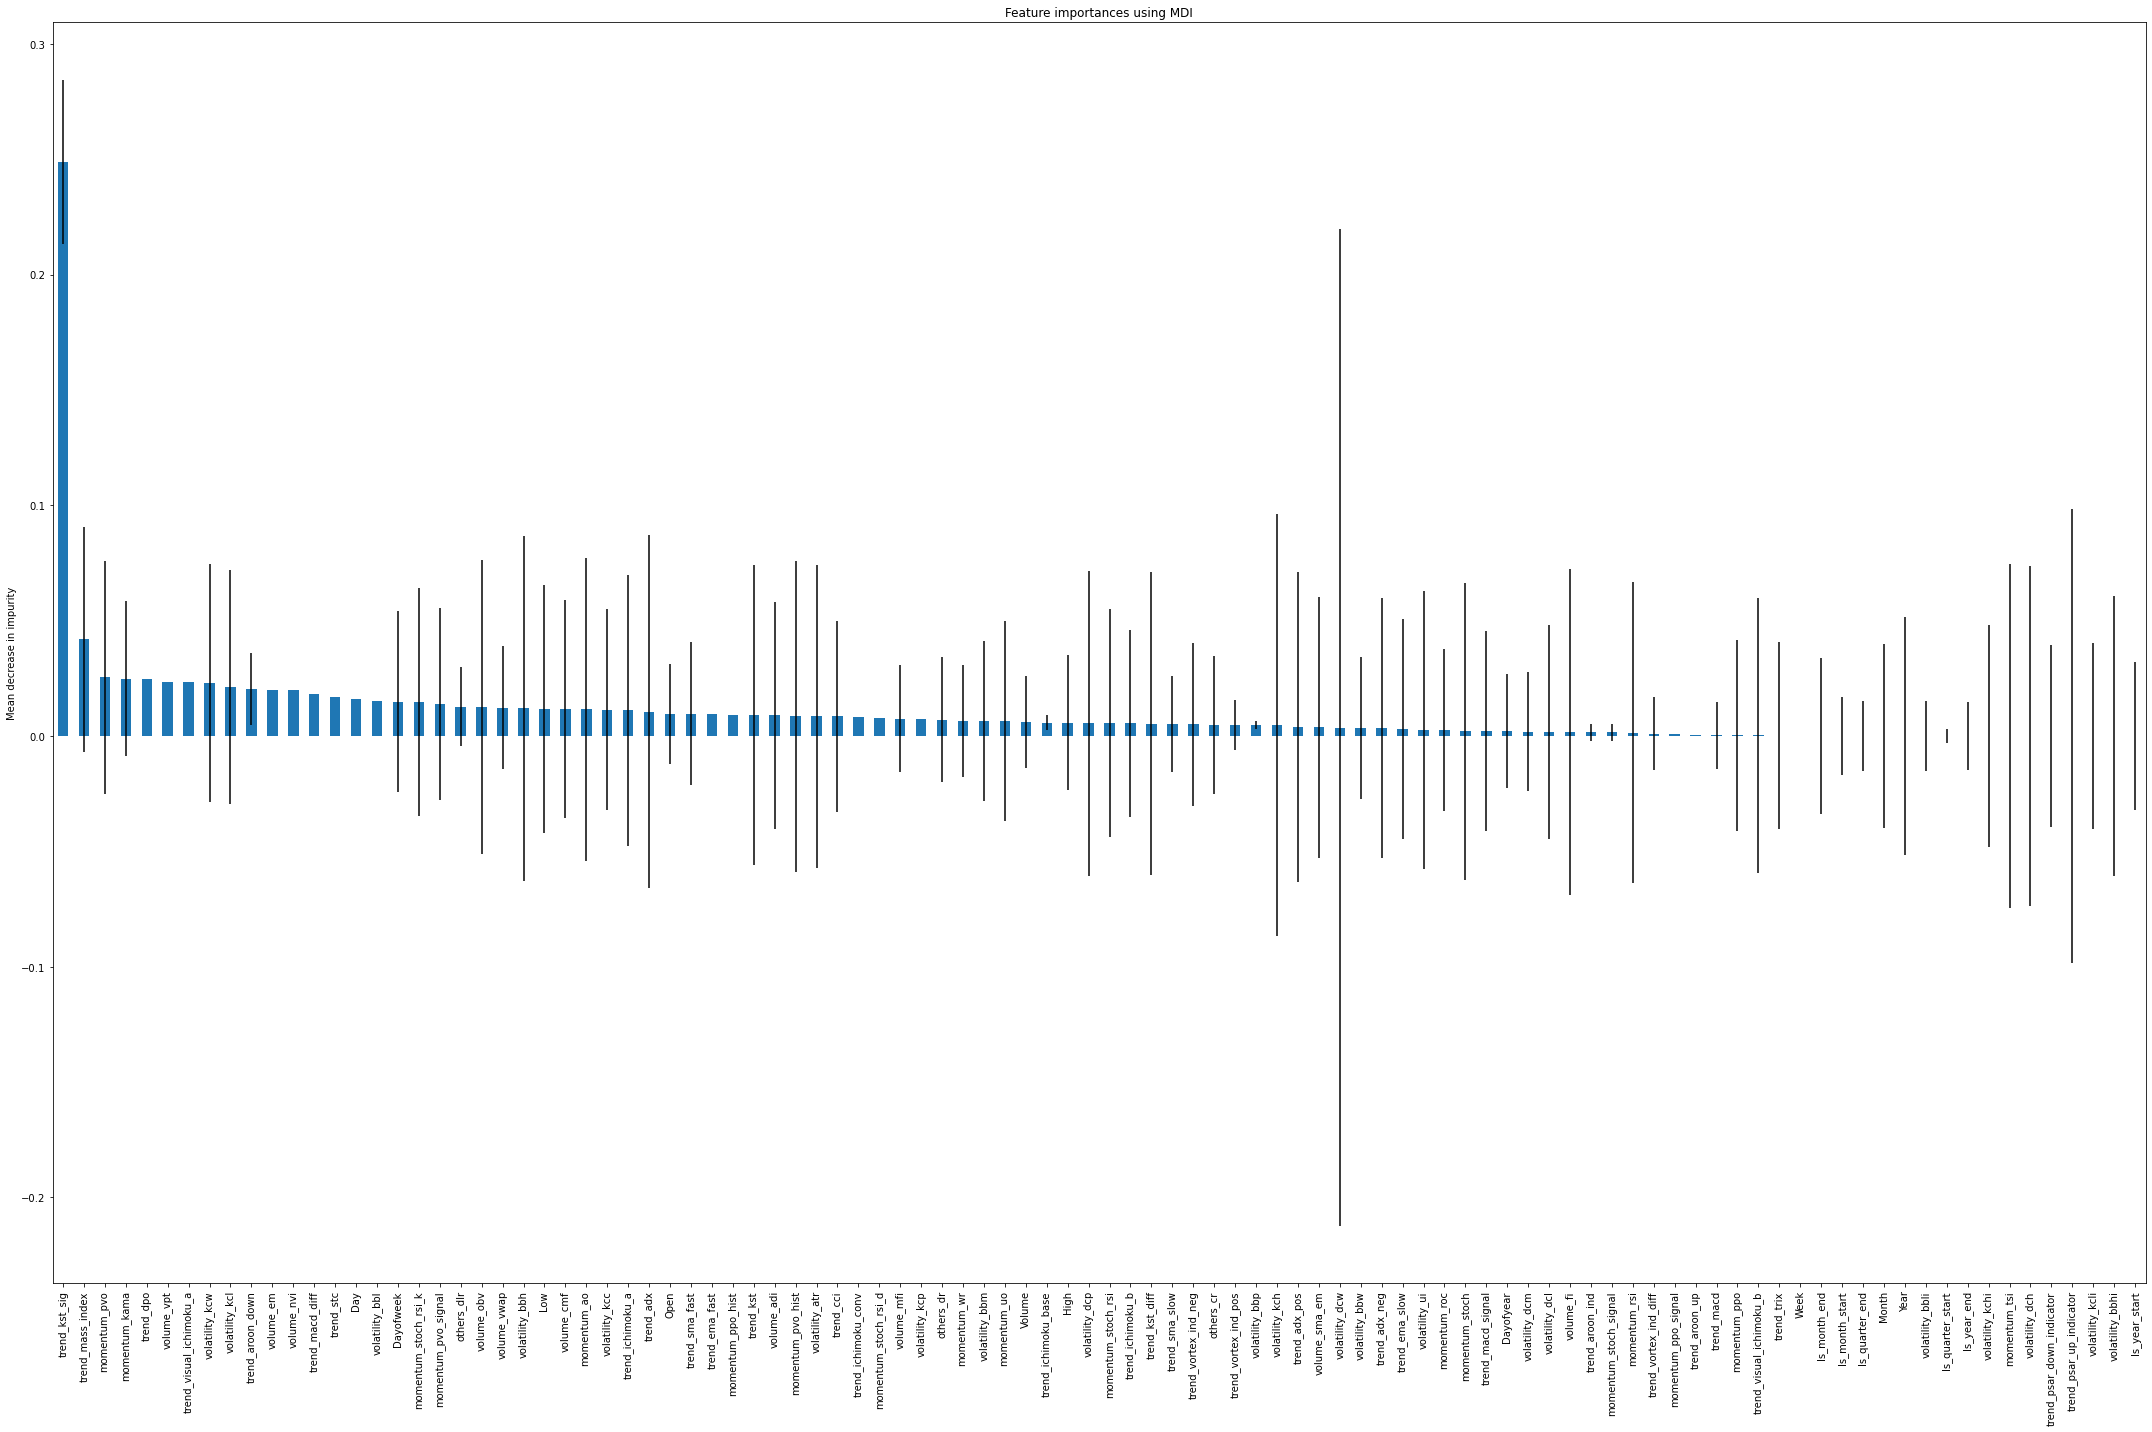

In [50]:
feature_names = [i for i in X_pandas.columns]
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(30,20))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [51]:
forest_importances.head(20)

trend_kst_sig              0.248872
trend_mass_index           0.041968
momentum_pvo               0.025406
momentum_kama              0.024918
trend_dpo                  0.024914
volume_vpt                 0.023578
trend_visual_ichimoku_a    0.023213
volatility_kcw             0.023018
volatility_kcl             0.021178
trend_aroon_down           0.020369
volume_em                  0.020122
volume_nvi                 0.019832
trend_macd_diff            0.018324
trend_stc                  0.017023
Day                        0.015913
volatility_bbl             0.015153
Dayofweek                  0.014813
momentum_stoch_rsi_k       0.014723
momentum_pvo_signal        0.014009
others_dlr                 0.012761
dtype: float64